# Notebook: Convolutional Neural Networks

In this notebook, we present the **Convolutional Neural Networks** and its application to image recognition.

## Contents
The structure of the notebook is as follows:
* Training a convnet from scratch on a small dataset
* Using a pre-trained convnet


## Sources
<!--BOOK_INFORMATION-->

i) the [Keras tutorials](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) by Francois Chollet.

ii) Chapter 5, Section 3 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff) by Francois Chollet.

iii) [Segmentations for Flower Image Datasets and Others](http://www.robots.ox.ac.uk/~vgg/data/bicos/) by  Yuning Chai, Victor Lempitsky and Andrew Zisserman.


## Data structure

'''This script goes along the blog post
"Building powerful image classification models using very little data" from blog.keras.io.
It uses data that can be downloaded at:
http://www.robots.ox.ac.uk/~vgg/data/flowers/17/
In our setup, we:
- created a data/ folder
- created train/ and validation/ subfolders inside data/
- created flower1/, flower2/ and flower3/ subfolders inside train/ and validation/
- put the pictures in each folder
So that we have 100 training examples for each class, and 297 validation examples in total.
In summary, this is our directory structure:
```
data/
    train/
        flower1/
            image_00001.jpg            
            ...
        flower2/
            image_00252.jpg            
            ...
        flower3/
            image_00446.jpg            
            ...
    validation/
        flower1/
            image_00101.jpg            
            ...
        flower2/
            image_00352.jpg            
            ...
        flower3/
            image_00546.jpg            
            ...
```
'''



### 1. Using convnets with small datasets

## Training a convnet from scratch on a small dataset

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in practice if you ever do computer vision in a professional context.

Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images. As a practical example, we will focus on classifying images as three species of flowers "flower1", "flower2" or "flower3", in a dataset containing only 597 pictures of all three species . We will use 300 pictures for training, 297 for validation.

We will train a model from scratch on what little data we have. We will start by naively training a small convnet on our 300 training samples, without any regularization, to set a baseline for what can be achieved. This will get us to a classification accuracy of up to 85%. 


## Building our network

Our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

Here, since we start from inputs of size 150x150 (a somewhat arbitrary choice), we end up with feature maps of size 17x17 right before the `Flatten` layer.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is decreasing (from 148x148 to 17x17). This is a pattern that you will see in almost all convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 3) and a `softmax` activation. This unit will encode the probability that the network is looking at one class or the others.


In [6]:
#Firt we define the data directories
import os, shutil

#Import the libraries
from keras import layers
from keras import models

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os

# The directory where we will store our dataset
base_dir = './data'
# Directories for our training and validation splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
num_classes=3;

#Declaration of the Neural Network model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

For our compilation step, we'll go with the `Adam` optimizer. We will use a categorical crossentropy as the loss which is the most apropiated in this case where we have a multi-class problem.

In [15]:
from keras import optimizers
import tensorflow as tf

#We have to specify the optimizer employed to train the classifier. We will use a Adam with learning rate equal to 2e-4 and a loss function based on categorical crossentropy
#The parameter metric define the performance metric employed to evaluate the classifier
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=2e-4),
              metrics=['acc'])

## Data preprocessing

Data should be formatted into appropriately pre-processed floating point tensors before being fed into our 
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image 
processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to 
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we 
will use here.

In [16]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#batch_size determines the number of images employed during the training for each gradient update (related to the weight optimization)
batch_size=10;

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical') #as we have a multi class classification

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 300 images belonging to 3 classes.
Found 297 images belonging to 3 classes.


Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators 
like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. 
Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before 
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the 
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 10-sample large, so it will take 30 batches until we see our target of 300 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. 

In [17]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=30,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=30)

c:\users\jose\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
30/30 [==============================] - 10s 329ms/step - loss: 1.1476 - acc: 0.4233 - val_loss: 0.9982 - val_acc: 0.5286
Epoch 2/15
30/30 [==============================] - 11s 354ms/step - loss: 0.8168 - acc: 0.6667 - val_loss: 0.6115 - val_acc: 0.8047
Epoch 3/15
30/30 [==============================] - 10s 351ms/step - loss: 0.4754 - acc: 0.8433 - val_loss: 0.4215 - val_acc: 0.8451
Epoch 4/15
30/30 [==============================] - 10s 340ms/step - loss: 0.2030 - acc: 0.9400 - val_loss: 0.2275 - val_acc: 0.9125
Epoch 5/15
30/30 [==============================] - 10s 340ms/step - loss: 0.1791 - acc: 0.9500 - val_loss: 0.5481 - val_acc: 0.7811
Epoch 6/15
30/30 [==============================] - 10s 332ms/step - loss: 0.2103 - acc: 0.9167 - val_loss: 0.4110 - val_acc: 0.8451
Epoch 7/15
30/30 [==============================] - 10s 338ms/step - loss: 0.0681 - acc: 0.9867 - val_loss: 0.1357 - val_acc: 0.9596
Epoch 8/15
30/30 [==============================] - 10s 335ms/step - 

Let's plot the loss and accuracy of the model over the training and validation data during training:

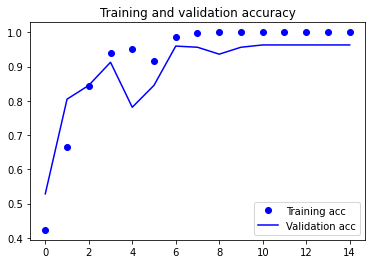

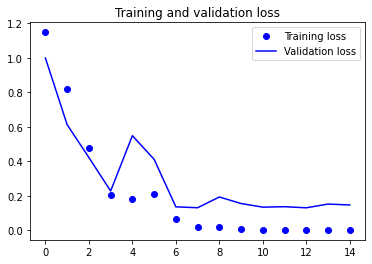

In [18]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Obtain the accuracy and loss data
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Plot the accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

#Plot the loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Not bad. The results obtained are quite good. Let's see if we can improve it using a pre-trained network

In [27]:
#Declaration of the Neural Network model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)     

In [30]:
#We have to specify the optimizer employed to train the classifier. We will use a Adam with learning rate equal to 2e-4 and a loss function based on categorical crossentropy
#The parameter metric define the performance metric employed to evaluate the classifier
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=2e-4),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=30,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=30)

Epoch 1/15
30/30 [==============================] - 8s 270ms/step - loss: 1.0089 - acc: 0.5433 - val_loss: 0.6424 - val_acc: 0.7980
Epoch 2/15
30/30 [==============================] - 10s 324ms/step - loss: 0.5331 - acc: 0.7867 - val_loss: 0.4950 - val_acc: 0.7980
Epoch 3/15
30/30 [==============================] - 9s 316ms/step - loss: 0.2538 - acc: 0.9067 - val_loss: 0.2001 - val_acc: 0.9226
Epoch 4/15
30/30 [==============================] - 11s 373ms/step - loss: 0.1565 - acc: 0.9567 - val_loss: 0.1164 - val_acc: 0.9562
Epoch 5/15
30/30 [==============================] - 10s 320ms/step - loss: 0.1218 - acc: 0.9533 - val_loss: 0.1529 - val_acc: 0.9428
Epoch 6/15
30/30 [==============================] - 9s 308ms/step - loss: 0.0996 - acc: 0.9767 - val_loss: 0.2685 - val_acc: 0.8923
Epoch 7/15
30/30 [==============================] - 9s 308ms/step - loss: 0.1857 - acc: 0.9367 - val_loss: 0.1479 - val_acc: 0.9428
Epoch 8/15
30/30 [==============================] - 10s 320ms/step - loss

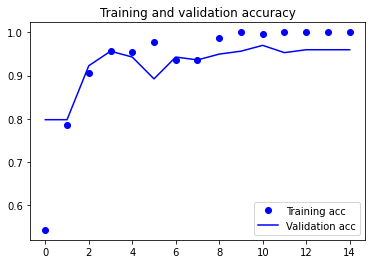

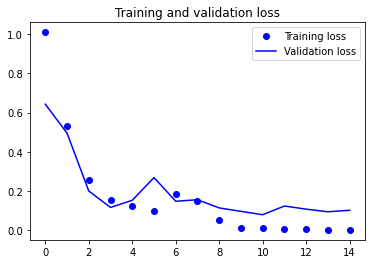

In [31]:
#Obtain the accuracy and loss data
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Plot the accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

#Plot the loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Epoch 1/15
30/30 [==============================] - 8s 272ms/step - loss: 1.0317 - acc: 0.4800 - val_loss: 0.6968 - val_acc: 0.7912
Epoch 2/15
30/30 [==============================] - 10s 318ms/step - loss: 0.5634 - acc: 0.7833 - val_loss: 0.4393 - val_acc: 0.8148
Epoch 3/15
30/30 [==============================] - 10s 329ms/step - loss: 0.3920 - acc: 0.8433 - val_loss: 0.2482 - val_acc: 0.8923
Epoch 4/15
30/30 [==============================] - 9s 315ms/step - loss: 0.2569 - acc: 0.9067 - val_loss: 0.1757 - val_acc: 0.9360
Epoch 5/15
30/30 [==============================] - 9s 314ms/step - loss: 0.1532 - acc: 0.9533 - val_loss: 0.1136 - val_acc: 0.9529
Epoch 6/15
30/30 [==============================] - 9s 313ms/step - loss: 0.2160 - acc: 0.9200 - val_loss: 0.3537 - val_acc: 0.8788
Epoch 7/15
30/30 [==============================] - 9s 313ms/step - loss: 0.2804 - acc: 0.9000 - val_loss: 0.2425 - val_acc: 0.9057
Epoch 8/15
30/30 [==============================] - 9s 313ms/step - loss: 

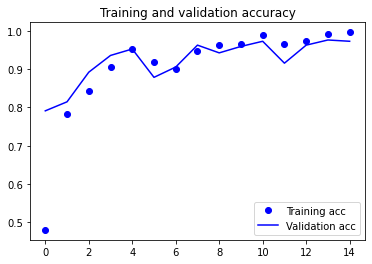

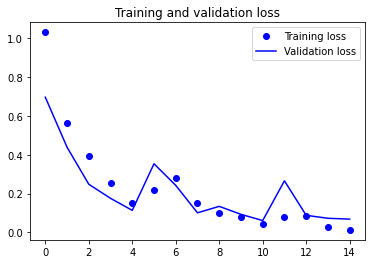

In [34]:
#Declaration of the Neural Network model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

#We have to specify the optimizer employed to train the classifier. We will use a Adam with learning rate equal to 2e-4 and a loss function based on categorical crossentropy
#The parameter metric define the performance metric employed to evaluate the classifier
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=2e-4),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=30,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=30)

#Obtain the accuracy and loss data
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Plot the accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

#Plot the loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Epoch 1/15
30/30 [==============================] - 9s 301ms/step - loss: 1.0829 - acc: 0.3900 - val_loss: 1.1294 - val_acc: 0.2862
Epoch 2/15
30/30 [==============================] - 10s 343ms/step - loss: 0.8227 - acc: 0.6400 - val_loss: 0.7399 - val_acc: 0.6566
Epoch 3/15
30/30 [==============================] - 10s 345ms/step - loss: 0.5340 - acc: 0.8167 - val_loss: 0.6885 - val_acc: 0.7407
Epoch 4/15
30/30 [==============================] - 10s 342ms/step - loss: 0.3054 - acc: 0.8800 - val_loss: 0.1810 - val_acc: 0.9360
Epoch 5/15
30/30 [==============================] - 10s 342ms/step - loss: 0.1757 - acc: 0.9333 - val_loss: 0.1203 - val_acc: 0.9562
Epoch 6/15
30/30 [==============================] - 10s 341ms/step - loss: 0.1356 - acc: 0.9533 - val_loss: 0.1648 - val_acc: 0.9394
Epoch 7/15
30/30 [==============================] - 10s 342ms/step - loss: 0.2184 - acc: 0.9033 - val_loss: 0.2705 - val_acc: 0.8822
Epoch 8/15
30/30 [==============================] - 10s 344ms/step - l

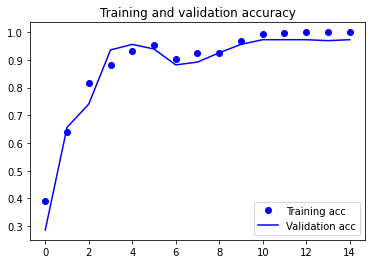

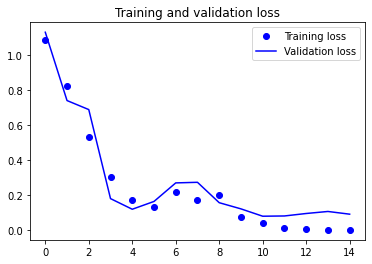

In [37]:
#Declaration of the Neural Network model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

#We have to specify the optimizer employed to train the classifier. We will use a Adam with learning rate equal to 2e-4 and a loss function based on categorical crossentropy
#The parameter metric define the performance metric employed to evaluate the classifier
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=2e-4),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=30,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=30)

#Obtain the accuracy and loss data
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Plot the accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

#Plot the loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Epoch 1/15
30/30 [==============================] - 11s 364ms/step - loss: 1.0753 - acc: 0.4167 - val_loss: 0.7551 - val_acc: 0.7239
Epoch 2/15
30/30 [==============================] - 11s 377ms/step - loss: 0.6412 - acc: 0.7367 - val_loss: 0.4324 - val_acc: 0.8653
Epoch 3/15
30/30 [==============================] - 11s 368ms/step - loss: 0.3070 - acc: 0.9033 - val_loss: 0.2503 - val_acc: 0.9158
Epoch 4/15
30/30 [==============================] - 11s 362ms/step - loss: 0.1102 - acc: 0.9767 - val_loss: 0.1671 - val_acc: 0.9428
Epoch 5/15
30/30 [==============================] - 11s 363ms/step - loss: 0.0516 - acc: 0.9933 - val_loss: 0.1693 - val_acc: 0.9360
Epoch 6/15
30/30 [==============================] - 11s 372ms/step - loss: 0.0212 - acc: 1.0000 - val_loss: 0.1119 - val_acc: 0.9663
Epoch 7/15
30/30 [==============================] - 11s 379ms/step - loss: 0.0097 - acc: 1.0000 - val_loss: 0.1093 - val_acc: 0.9663
Epoch 8/15
30/30 [==============================] - 11s 366ms/step - 

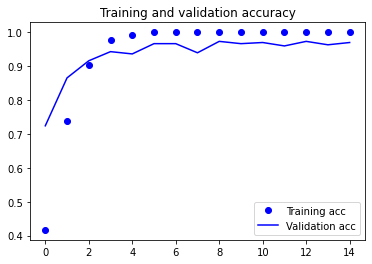

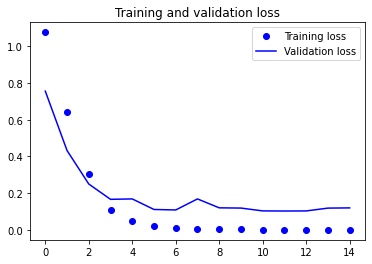

In [38]:
#Declaration of the Neural Network model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3), padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

#We have to specify the optimizer employed to train the classifier. We will use a Adam with learning rate equal to 2e-4 and a loss function based on categorical crossentropy
#The parameter metric define the performance metric employed to evaluate the classifier
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=2e-4),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=30,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=30)

#Obtain the accuracy and loss data
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Plot the accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

#Plot the loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Epoch 1/15
30/30 [==============================] - 13s 429ms/step - loss: 0.9313 - acc: 0.5867 - val_loss: 1.3345 - val_acc: 0.4444
Epoch 2/15
30/30 [==============================] - 14s 471ms/step - loss: 0.6074 - acc: 0.7267 - val_loss: 0.2846 - val_acc: 0.9057
Epoch 3/15
30/30 [==============================] - 14s 469ms/step - loss: 0.3555 - acc: 0.8533 - val_loss: 0.3193 - val_acc: 0.8687
Epoch 4/15
30/30 [==============================] - 14s 469ms/step - loss: 0.1932 - acc: 0.9333 - val_loss: 0.2213 - val_acc: 0.9259
Epoch 5/15
30/30 [==============================] - 14s 472ms/step - loss: 0.2035 - acc: 0.9267 - val_loss: 0.3961 - val_acc: 0.8316
Epoch 6/15
30/30 [==============================] - 14s 478ms/step - loss: 0.1974 - acc: 0.9167 - val_loss: 0.1655 - val_acc: 0.9293
Epoch 7/15
30/30 [==============================] - 14s 470ms/step - loss: 0.1148 - acc: 0.9600 - val_loss: 0.1201 - val_acc: 0.9529
Epoch 8/15
30/30 [==============================] - 14s 475ms/step - 

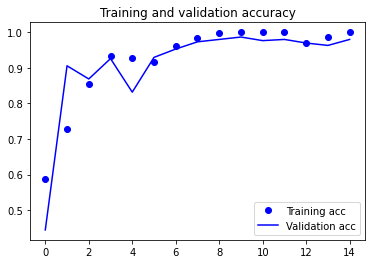

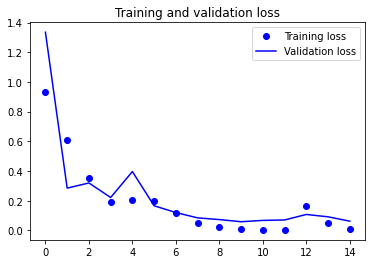

In [40]:
#Declaration of the Neural Network model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3), padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(1024, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

#We have to specify the optimizer employed to train the classifier. We will use a Adam with learning rate equal to 2e-4 and a loss function based on categorical crossentropy
#The parameter metric define the performance metric employed to evaluate the classifier
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=2e-4),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=30,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=30)

#Obtain the accuracy and loss data
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Plot the accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

#Plot the loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Epoch 1/15
30/30 [==============================] - 18s 593ms/step - loss: 0.9348 - acc: 0.5233 - val_loss: 0.7325 - val_acc: 0.6397
Epoch 2/15
30/30 [==============================] - 18s 616ms/step - loss: 0.5182 - acc: 0.8033 - val_loss: 0.2394 - val_acc: 0.9158
Epoch 3/15
30/30 [==============================] - 18s 607ms/step - loss: 0.2377 - acc: 0.9000 - val_loss: 0.3683 - val_acc: 0.8620
Epoch 4/15
30/30 [==============================] - 18s 616ms/step - loss: 0.1986 - acc: 0.9267 - val_loss: 0.1686 - val_acc: 0.9360
Epoch 5/15
30/30 [==============================] - 18s 607ms/step - loss: 0.1373 - acc: 0.9700 - val_loss: 0.1173 - val_acc: 0.9630
Epoch 6/15
30/30 [==============================] - 18s 615ms/step - loss: 0.0613 - acc: 0.9700 - val_loss: 0.2092 - val_acc: 0.9495
Epoch 7/15
30/30 [==============================] - 19s 623ms/step - loss: 0.2741 - acc: 0.8967 - val_loss: 0.1679 - val_acc: 0.9461
Epoch 8/15
30/30 [==============================] - 18s 609ms/step - 

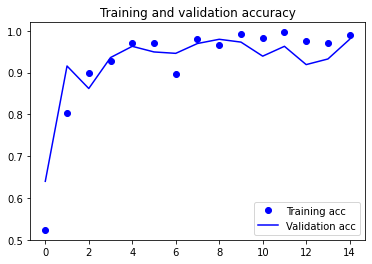

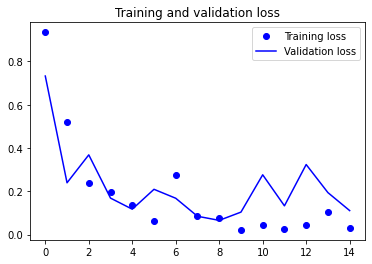

In [41]:
#Declaration of the Neural Network model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3), padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(1024, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

#We have to specify the optimizer employed to train the classifier. We will use a Adam with learning rate equal to 2e-4 and a loss function based on categorical crossentropy
#The parameter metric define the performance metric employed to evaluate the classifier
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=2e-4),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=30,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=30)

#Obtain the accuracy and loss data
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Plot the accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

#Plot the loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()